In [1]:
import math
import torch

from matplotlib import pyplot as plt
%matplotlib inline

import os
import argparse
import pandas as pd
from pandas import factorize
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
#from sklearn.model_selection import KFold

import gpytorch
import itertools

import warnings
warnings.filterwarnings('ignore')


In [ ]:
"""
import m3hgpr
from m3hgpr.config import get_cfg_defaults_all
from m3hgpr.load_data import Data_set
from m3hgpr.models import singleGP_gpytorch,rf_sklearn,singleGP_gpytorch_train,singleGP_gpytorch_reference,MultitaskGPModel,MTMOGP
from m3hgpr.train import CV_Trainer
"""

In [2]:
from m3gpr.config import get_cfg_defaults_all
from m3gpr.load_data import Data_set
from m3gpr.models import singleGP_gpytorch,rf_sklearn,singleGP_gpytorch_train,singleGP_gpytorch_reference,MultitaskGPModel,MTMOGP
from m3gpr.train import CV_Trainer

In [3]:
cfg = get_cfg_defaults_all()
os.chdir('/Users/chenya68/Documents/GitHub/BFO')
parser = argparse.ArgumentParser(description="Configure files")
parser.add_argument("--cfg", required=True, help="path to config file", type=str)
args = parser.parse_args(['--cfg', 'bfo-data/harpoon/harpoon_dataset.yaml'])
cfg.merge_from_file(args.cfg)

cfg.freeze()
setup_data = Data_set(cfg, 1)
print(cfg.MODEL.MODEL_NAME)
print(cfg.MODEL.Y_SCALE)

#df_x, df_y_wide, df_y_long = setup_data.Load_data_set()
df_x, df_y,ls_X_train,ls_X_test,ls_y_train,ls_y_test, obj_y_scaler= setup_data.Load_data_set()
print(df_x.shape)
print(df_y.shape)
#print(df_y_wide.shape)
#print(df_y_long.shape)

MO
y-stand
ohe
(24, 9)
(24, 6)


In [4]:
df_y_corr = df_y.corr()
df_y_corr.to_csv(cfg.PATH.DATA_PATH + '/wide_df_y_corr.csv')
print(df_y_corr)

               _Dimer_HMW__1  _Monomer_1  _Dimer_HMW__2  _Monomer_2  \
_Dimer_HMW__1       1.000000   -0.974455       0.911054   -0.835600   
_Monomer_1         -0.974455    1.000000      -0.905202    0.850751   
_Dimer_HMW__2       0.911054   -0.905202       1.000000   -0.960420   
_Monomer_2         -0.835600    0.850751      -0.960420    1.000000   
_Dimer_HMW__3       0.874988   -0.854303       0.724558   -0.635937   
_Monomer_3         -0.725131    0.723048      -0.565699    0.509656   

               _Dimer_HMW__3  _Monomer_3  
_Dimer_HMW__1       0.874988   -0.725131  
_Monomer_1         -0.854303    0.723048  
_Dimer_HMW__2       0.724558   -0.565699  
_Monomer_2         -0.635937    0.509656  
_Dimer_HMW__3       1.000000   -0.930695  
_Monomer_3         -0.930695    1.000000  


In [5]:
import numpy as np

def correlation_to_covariance(corr_matrix, std_devs):
    """
    Convert a correlation matrix to a covariance matrix.

    Parameters:
        corr_matrix (np.ndarray): Square correlation matrix (n x n).
        std_devs (np.ndarray): 1D array of standard deviations (length n).

    Returns:
        np.ndarray: Covariance matrix (n x n).
    """
    # Validate inputs
    corr_matrix = np.array(corr_matrix, dtype=float)
    std_devs = np.array(std_devs, dtype=float)

    if corr_matrix.shape[0] != corr_matrix.shape[1]:
        raise ValueError("Correlation matrix must be square.")
    if corr_matrix.shape[0] != std_devs.shape[0]:
        raise ValueError("Length of std_devs must match matrix size.")
    if not np.allclose(corr_matrix, corr_matrix.T, atol=1e-8):
        raise ValueError("Correlation matrix must be symmetric.")
    if np.any(np.diag(corr_matrix) != 1):
        raise ValueError("Diagonal elements of correlation matrix must be 1.")

    # Create diagonal matrix of standard deviations
    D = np.diag(std_devs)

    # Covariance = D * Corr * D
    cov_matrix = D @ corr_matrix @ D
    return cov_matrix


# Example usage
corr = df_y_corr.values
std_devs = df_y.std().to_list()

cov = correlation_to_covariance(corr, std_devs)
cov = torch.nn.Parameter(torch.Tensor(cov))
print("Covariance Matrix:\n", cov)


Covariance Matrix:
 Parameter containing:
tensor([[ 0.8104, -0.9076,  0.2647, -0.2858,  0.7904, -0.8965],
        [-0.9076,  1.0704, -0.3023,  0.3344, -0.8869,  1.0273],
        [ 0.2647, -0.3023,  0.1042, -0.1178,  0.2347, -0.2508],
        [-0.2858,  0.3344, -0.1178,  0.1443, -0.2424,  0.2659],
        [ 0.7904, -0.8869,  0.2347, -0.2424,  1.0069, -1.2825],
        [-0.8965,  1.0273, -0.2508,  0.2659, -1.2825,  1.8860]],
       requires_grad=True)


In [38]:
weight = torch.nn.Parameter(torch.randn((3,3), requires_grad=True))
weight

Parameter containing:
tensor([[ 0.4160,  0.3756, -0.5200],
        [-2.1646, -0.1408, -2.1781],
        [ 0.5680,  0.2515, -0.0090]], requires_grad=True)

## Single GP Cross-Validation

In [6]:
if True:
    sgp_cv_trainer = CV_Trainer(cfg,ls_X_train,ls_X_test,ls_y_train,ls_y_test,obj_y_scaler)
    combs,ls_model_from_combs,ls_arr_cv_mae,ls_arr_cv_r2,ls_arr_cv_err,mean_arr_cv_mae,mean_arr_cv_r2,mean_arr_cv_err = sgp_cv_trainer.set_up_sgp_cv()
    
    if cfg.MODEL.SPLIT == 'by-task':
        num_tasks = cfg.DATA.NUM_TASKS
    else:
        num_tasks = 1
    
    #num_tasks = cfg.DATA.NUM_TASKS
    num_outputs = cfg.DATA.NUM_OUTPUTS
    num_total_outputs = num_outputs*num_tasks
    arr_metrics = np.zeros((3,1+num_total_outputs)) #row:mae, r2, avg_std; col: total mean, task1(output1), task2(output2),...

    print('number of tasks that are being compared: ',num_total_outputs)

    best_idx = np.argmin(mean_arr_cv_mae[1,:])
    #best_idx = np.argmax(mean_arr_cv_r2[1,:])

    print('best_idx',best_idx)
    print('best combinations: ',combs[best_idx])

    arr_metrics[0,0] = np.min(mean_arr_cv_mae[1,:])
    arr_metrics[1,0] = np.max(mean_arr_cv_r2[1,:])
    arr_metrics[2,0] = mean_arr_cv_err[1,best_idx]

    print('best mean mae %.3f' % arr_metrics[0,0])
    print('best mean r2 %.3f' % arr_metrics[1,0])
    print('best mean err %.3f' % arr_metrics[2,0])
    
    cols_target_new = ['total']
    for task_ind in range(num_tasks):
        for out_ind in range(num_outputs):
            j = out_ind + num_outputs*task_ind
    #for j in range(num_total_outputs):
            j_name = 'Task_'+str(task_ind+1) + '_Output_'+str(out_ind+1)
            cols_target_new.append(j_name)
            arr_metrics[0,j+1] = ls_arr_cv_mae[j][1,best_idx]
            arr_metrics[1,j+1] = ls_arr_cv_r2[j][1,best_idx]
            arr_metrics[2,j+1] = ls_arr_cv_err[j][1,best_idx]
            print('best mae of target %d is %.3f' %(j,ls_arr_cv_mae[j][1,best_idx]))
            print('best r2 of target %d is %.3f' %(j,ls_arr_cv_r2[j][1,best_idx]))
            print('best err of target %d is %.3f' % (j,ls_arr_cv_err[j][1,best_idx]))
    
    df_test_metrics = pd.DataFrame(np.round(arr_metrics,3),columns = cols_target_new, 
                               index = [cfg.MODEL.METRIC,'R2','AVG_STD'])
    print(df_test_metrics)
    
    #output_path = '/'.join([cfg.PATH.RESULT,cfg.MISC.DATA_NAME,cfg.MODEL.MODEL_NAME,cfg.MODEL.SPLIT,cfg.MISC.DATE])
    df_test_metrics.to_csv(setup_data.output_path+'/df_test_metrics.csv')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
number of tasks that are being compared:  2
best_idx 16
best combinations:  (4.0, 0.1, 200)
best mean mae 0.543
best mean r2 0.768
best mean err 0.933
best mae of target 0 is 0.360
best r2 of target 0 is 0.859
best err of target 0 is 0.641
best mae of target 1 is 0.725
best r2 of target 1 is 0.676
best err of target 1 is 1.224
         total  Task_1_Output_1  Task_1_Output_2
RMSE     0.543            0.360            0.725
R2       0.768            0.859            0.676
AVG_STD  0.933            0.641            1.224


## MO Cross-Validation

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


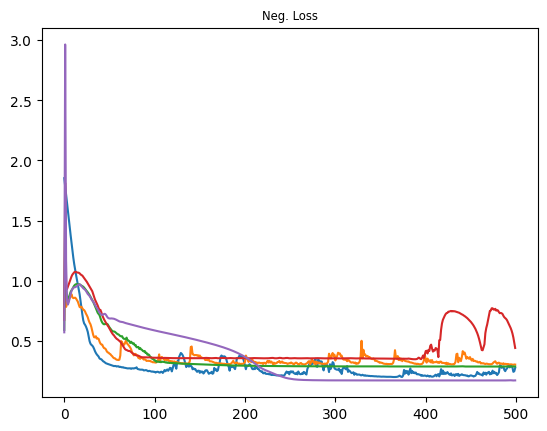

In [6]:
mo_cv_trainer = CV_Trainer(cfg,ls_X_train,ls_X_test,ls_y_train,ls_y_test,obj_y_scaler,cov)
combs,ls_model_from_combs,ls_arr_cv_mae,ls_arr_cv_r2,ls_arr_cv_err,mean_arr_cv_mae,mean_arr_cv_r2,mean_arr_cv_err = mo_cv_trainer.set_up_cv_model()

In [ ]:
"""
print('both targets')
best_idx = np.argmin(mean_arr_cv_mae[1,:])

print('best_idx',best_idx)
print('mean min mae %.3f' %(np.min(mean_arr_cv_mae[1,:])))

best_idx = np.argmax(mean_arr_cv_r2[1,:])
#print('best_idx',best_idx)
print('mean max r2 %.3f' %(np.max(mean_arr_cv_r2[1,:])))
print('mean min err %.3f' %(mean_arr_cv_err[1,best_idx]))

for j in range(cfg.DATA.NUM_OUTPUTS):
    print('min mae of target %d is %.3f' %(j, ls_arr_cv_mae[j][1,best_idx]))
#print('min mae target 1',ls_arr_cv_mae[1][1,best_idx])

    print('max r2 of target %d is %.3f' %(j,ls_arr_cv_r2[j][1,best_idx]))
#print('max r2 target 1',arr_cv_r2_1[1,best_idx])

    print('min err of target %d is %.3f' %(j,ls_arr_cv_err[j][1,best_idx]))
#print('min err target 1',arr_cv_err_1[1,best_idx])

print(combs[best_idx])
"""


In [11]:
#len(ls_model_from_combs)
model = ls_model_from_combs[-1]

for name, param in model.named_parameters():
        print(f"Parameter Name: {name}, Shape: {param.shape}")

Parameter Name: likelihood.task_noise_covar_factor, Shape: torch.Size([6, 4])
Parameter Name: likelihood.raw_noise, Shape: torch.Size([1])
Parameter Name: mean_module.base_means.0.raw_constant, Shape: torch.Size([])
Parameter Name: mean_module.base_means.1.raw_constant, Shape: torch.Size([])
Parameter Name: mean_module.base_means.2.raw_constant, Shape: torch.Size([])
Parameter Name: mean_module.base_means.3.raw_constant, Shape: torch.Size([])
Parameter Name: mean_module.base_means.4.raw_constant, Shape: torch.Size([])
Parameter Name: mean_module.base_means.5.raw_constant, Shape: torch.Size([])
Parameter Name: covar_module.task_covar_module.covar_factor, Shape: torch.Size([6, 2])
Parameter Name: covar_module.task_covar_module.raw_var, Shape: torch.Size([6])
Parameter Name: covar_module.data_covar_module.raw_lengthscale, Shape: torch.Size([1, 1])


In [8]:
output_kern = model.covar_module
covar_factor = output_kern.task_covar_module.covar_factor
print('W W^T + diag(v) is the output kernel covariance matrix: ')
B = output_kern.task_covar_module._eval_covar_matrix().detach().numpy()
print(B)

print('---Manually calculating covariance matrix---')
W = covar_factor.detach().numpy()
B2 = np.dot(W,W.T)+np.diag(output_kern.task_covar_module.raw_var.detach().numpy())
print('W W^T + diag(v) is the output kernel covariance matrix: ')
print(B2)


print('Correlation matrix between outputs')
C = (B/np.sqrt(np.diag(B))).T/np.sqrt(np.diag(B))
print(C)


W W^T + diag(v) is the output kernel covariance matrix: 
[[ 1.7858342 -1.7191333  1.5873708 -1.4668404  1.833238  -1.7178316]
 [-1.7191333  1.6689838 -1.5137453  1.3952757 -1.7978863  1.6974883]
 [ 1.5873708 -1.5137453  1.4925506 -1.3975146  1.4662056 -1.3076392]
 [-1.4668404  1.3952757 -1.3975146  1.3125056 -1.317464   1.1582286]
 [ 1.833238  -1.7978863  1.4662056 -1.317464   2.2199268 -2.2156   ]
 [-1.7178316  1.6974883 -1.3076392  1.1582286 -2.2156     2.257922 ]]
---Manually calculating covariance matrix---
W W^T + diag(v) is the output kernel covariance matrix: 
[[ -4.7941604  -1.7191333   1.5873708  -1.4668404   1.833238   -1.7178316]
 [ -1.7191333  -2.9636106  -1.5137453   1.3952757  -1.7978863   1.6974883]
 [  1.5873708  -1.5137453 -11.316903   -1.3975146   1.4662056  -1.3076392]
 [ -1.4668404   1.3952757  -1.3975146  -8.86358    -1.317464    1.1582286]
 [  1.833238   -1.7978863   1.4662056  -1.317464   -7.306846   -2.2156   ]
 [ -1.7178316   1.6974883  -1.3076392   1.1582286  

In [9]:
if True:
    if cfg.MODEL.SPLIT == 'by-task':
        num_tasks = cfg.DATA.NUM_TASKS
    else:
        num_tasks = 1
    
    #num_tasks = cfg.DATA.NUM_TASKS
    num_outputs = cfg.DATA.NUM_OUTPUTS
    num_total_outputs = num_outputs*num_tasks
    arr_metrics = np.zeros((3,1+num_total_outputs)) #row:mae, r2, avg_std; col: total mean, task1(output1), task2(output2),...

    print('number of tasks that are being compared: ',num_total_outputs)

    best_idx = np.argmin(mean_arr_cv_mae[1,:])
    #best_idx = np.argmax(mean_arr_cv_r2[1,:])

    print('best_idx',best_idx)
    print('best combinations: ',combs[best_idx])

    arr_metrics[0,0] = np.min(mean_arr_cv_mae[1,:])
    arr_metrics[1,0] = np.max(mean_arr_cv_r2[1,:])
    arr_metrics[2,0] = mean_arr_cv_err[1,best_idx]

    print('best mean mae %.3f' % arr_metrics[0,0])
    print('best mean r2 %.3f' % arr_metrics[1,0])
    print('best mean err %.3f' % arr_metrics[2,0])
        
    cols_target_new = ['total']
    for task_ind in range(num_tasks):
        for out_ind in range(num_outputs):
            j = out_ind + num_outputs*task_ind
    #for j in range(num_total_outputs):
            j_name = 'Task_'+str(task_ind+1) + '_Output_'+str(out_ind+1)
            cols_target_new.append(j_name)
            arr_metrics[0,j+1] = ls_arr_cv_mae[j][1,best_idx]
            arr_metrics[1,j+1] = ls_arr_cv_r2[j][1,best_idx]
            arr_metrics[2,j+1] = ls_arr_cv_err[j][1,best_idx]
            print('best mae of target %d is %.3f' %(j,ls_arr_cv_mae[j][1,best_idx]))
            print('best r2 of target %d is %.3f' %(j,ls_arr_cv_r2[j][1,best_idx]))
            print('best err of target %d is %.3f' % (j,ls_arr_cv_err[j][1,best_idx]))
    
    df_test_metrics = pd.DataFrame(np.round(arr_metrics,3),columns = cols_target_new, 
                               index = [cfg.MODEL.METRIC,'R2','AVG_STD'])
    print(df_test_metrics)
    
    df_test_metrics.to_csv(setup_data.output_path+'/df_test_metrics.csv')

number of tasks that are being compared:  6
best_idx 0
best combinations:  (0.1, 500)
best mean mae 0.489
best mean r2 0.499
best mean err 0.904
best mae of target 0 is 0.470
best r2 of target 0 is 0.427
best err of target 0 is 0.875
best mae of target 1 is 0.578
best r2 of target 1 is 0.579
best err of target 1 is 1.098
best mae of target 2 is 0.211
best r2 of target 2 is 0.502
best err of target 2 is 0.397
best mae of target 3 is 0.296
best r2 of target 3 is 0.420
best err of target 3 is 0.524
best mae of target 4 is 0.515
best r2 of target 4 is 0.650
best err of target 4 is 0.990
best mae of target 5 is 0.863
best r2 of target 5 is 0.418
best err of target 5 is 1.541
         total  Task_1_Output_1  Task_1_Output_2  Task_2_Output_1  \
RMSE     0.489            0.470            0.578            0.211   
R2       0.499            0.427            0.579            0.502   
AVG_STD  0.904            0.875            1.098            0.397   

         Task_2_Output_2  Task_3_Output_1  T

## MTMO Cross validation

In [12]:
if True:
    mtmo_cv_trainer = CV_Trainer(cfg,ls_X_train,ls_X_test,ls_y_train,ls_y_test,obj_y_scaler)
    combs,ls_model_from_combs,ls_arr_cv_mae,ls_arr_cv_r2,ls_arr_cv_err,mean_arr_cv_mae,mean_arr_cv_r2,mean_arr_cv_err = mtmo_cv_trainer.set_up_cv_model()

    if cfg.MODEL.SPLIT == 'by-task':
        num_tasks = cfg.DATA.NUM_TASKS
    else:
        num_tasks = 1
    num_outputs = cfg.DATA.NUM_OUTPUTS
    num_total_outputs = num_outputs*num_tasks
    arr_metrics = np.zeros((3,1+num_total_outputs)) #row:mae, r2, avg_std; col: total mean, task1(output1), task2(output2),...

    print('number of tasks that are being compared: ',num_total_outputs)

    best_idx = np.argmin(mean_arr_cv_mae[1,:])
    #best_idx = np.argmax(mean_arr_cv_r2[1,:])

    print('best_idx',best_idx)
    print('best combinations: ',combs[best_idx])

    arr_metrics[0,0] = np.min(mean_arr_cv_mae[1,:])
    arr_metrics[1,0] = np.max(mean_arr_cv_r2[1,:])
    arr_metrics[2,0] = mean_arr_cv_err[1,best_idx]

    print('best mean mae %.3f' % arr_metrics[0,0])
    print('best mean r2 %.3f' % arr_metrics[1,0])
    print('best mean err %.3f' % arr_metrics[2,0])
    
    cols_target_new = ['total']
    #for j in range(cfg.DATA.NUM_OUTPUTS):
    for task_ind in range(num_tasks):
        for out_ind in range(num_outputs):
            j = out_ind + num_outputs*task_ind
            j_name = 'Task_'+str(task_ind+1) + '_Output_'+str(out_ind+1)
            cols_target_new.append(j_name)
            arr_metrics[0,j+1] = ls_arr_cv_mae[j][1,best_idx]
            arr_metrics[1,j+1] = ls_arr_cv_r2[j][1,best_idx]
            arr_metrics[2,j+1] = ls_arr_cv_err[j][1,best_idx]
            print('best mae of target %d is %.3f' %(j,ls_arr_cv_mae[j][1,best_idx]))
            print('best r2 of target %d is %.3f' %(j,ls_arr_cv_r2[j][1,best_idx]))
            print('best err of target %d is %.3f' % (j,ls_arr_cv_err[j][1,best_idx]))
    
    df_test_metrics = pd.DataFrame(np.round(arr_metrics,3),columns = cols_target_new, 
                               index = [cfg.MODEL.METRIC,'R2','AVG_STD'])
    print(df_test_metrics)
    
    output_path = '/'.join([cfg.PATH.RESULT,cfg.MISC.DATA_NAME,cfg.MODEL.MODEL_NAME,cfg.MODEL.SPLIT,cfg.MISC.DATE,'num_tasks_'+str(cfg.DATA.NUM_TASKS)])
    df_test_metrics.to_csv(output_path+'/df_test_metrics.csv')

number of tasks that are being compared:  4
best_idx 7
best combinations:  (0.15, 1100)
best mean mae 0.502
best mean r2 0.578
best mean err 0.879
best mae of target 0 is 0.363
best r2 of target 0 is 0.616
best err of target 0 is 0.612
best mae of target 1 is 0.517
best r2 of target 1 is 0.483
best err of target 1 is 1.142
best mae of target 2 is 0.368
best r2 of target 2 is 0.789
best err of target 2 is 0.609
best mae of target 3 is 0.759
best r2 of target 3 is 0.422
best err of target 3 is 1.151
         total  Task_1_Output_1  Task_1_Output_2  Task_2_Output_1  \
RMSE     0.502            0.363            0.517            0.368   
R2       0.578            0.616            0.483            0.789   
AVG_STD  0.879            0.612            1.142            0.609   

         Task_2_Output_2  
RMSE               0.759  
R2                 0.422  
AVG_STD            1.151  


## MTMO-LMGP CV

In [5]:
if True:
    mtmolmgp_cv_trainer = CV_Trainer(cfg,ls_X_train,ls_X_test,ls_y_train,ls_y_test,obj_y_scaler)
    combs,ls_model_from_combs,ls_arr_cv_mae,ls_arr_cv_r2,ls_arr_cv_err,mean_arr_cv_mae,mean_arr_cv_r2,mean_arr_cv_err = mtmolmgp_cv_trainer.set_up_cv_model()

    if cfg.MODEL.SPLIT == 'by-task':
        num_tasks = cfg.DATA.NUM_TASKS
    else:
        num_tasks = 1
    num_outputs = cfg.DATA.NUM_OUTPUTS
    num_total_outputs = num_outputs*num_tasks
    arr_metrics = np.zeros((3,1+num_total_outputs)) #row:mae, r2, avg_std; col: total mean, task1(output1), task2(output2),...

    print('number of tasks that are being compared: ',num_total_outputs)

    best_idx = np.argmin(mean_arr_cv_mae[1,:])
    #best_idx = np.argmax(mean_arr_cv_r2[1,:])

    print('best_idx',best_idx)
    print('best combinations: ',combs[best_idx])

    arr_metrics[0,0] = np.min(mean_arr_cv_mae[1,:])
    arr_metrics[1,0] = np.max(mean_arr_cv_r2[1,:])
    arr_metrics[2,0] = mean_arr_cv_err[1,best_idx]

    print('best mean mae %.3f' % arr_metrics[0,0])
    print('best mean r2 %.3f' % arr_metrics[1,0])
    print('best mean err %.3f' % arr_metrics[2,0])
    
    cols_target_new = ['total']
    #for j in range(cfg.DATA.NUM_OUTPUTS):
    for task_ind in range(num_tasks):
        for out_ind in range(num_outputs):
            j = out_ind + num_outputs*task_ind
            j_name = 'Task_'+str(task_ind+1) + '_Output_'+str(out_ind+1)
            cols_target_new.append(j_name)
            arr_metrics[0,j+1] = ls_arr_cv_mae[j][1,best_idx]
            arr_metrics[1,j+1] = ls_arr_cv_r2[j][1,best_idx]
            arr_metrics[2,j+1] = ls_arr_cv_err[j][1,best_idx]
            print('best mae of target %d is %.3f' %(j,ls_arr_cv_mae[j][1,best_idx]))
            print('best r2 of target %d is %.3f' %(j,ls_arr_cv_r2[j][1,best_idx]))
            print('best err of target %d is %.3f' % (j,ls_arr_cv_err[j][1,best_idx]))
    
    df_test_metrics = pd.DataFrame(np.round(arr_metrics,3),columns = cols_target_new, 
                               index = ['MAE','R2','AVG_STD'])
    print(df_test_metrics)
    
    output_path = '/'.join([cfg.PATH.RESULT,cfg.MISC.DATA_NAME,cfg.MODEL.MODEL_NAME,cfg.MODEL.SPLIT,cfg.MISC.DATE,'num_tasks_'+str(cfg.DATA.NUM_TASKS)])
    df_test_metrics.to_csv(output_path+'/df_test_metrics.csv')

## Learning the model's parameters has started ##


Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Epoch 99 - loss 73.5903: 100%|██████████| 100/100 [00:00<00:00, 114.78it/s]


## Learning the model's parameters is successfully finished ##
## Learning the model's parameters has started ##


Epoch 99 - loss 48.7822: 100%|██████████| 100/100 [00:01<00:00, 77.85it/s] 


## Learning the model's parameters is successfully finished ##
## Learning the model's parameters has started ##


Epoch 99 - loss 41.9380: 100%|██████████| 100/100 [00:01<00:00, 56.99it/s]


## Learning the model's parameters is successfully finished ##
## Learning the model's parameters has started ##


Epoch 99 - loss 51.6604: 100%|██████████| 100/100 [00:02<00:00, 43.13it/s]


## Learning the model's parameters is successfully finished ##
## Learning the model's parameters has started ##


Epoch 99 - loss 49.3615: 100%|██████████| 100/100 [00:02<00:00, 36.10it/s]


## Learning the model's parameters is successfully finished ##
## Learning the model's parameters has started ##


Epoch 99 - loss 47.0913: 100%|██████████| 100/100 [00:03<00:00, 25.75it/s]


## Learning the model's parameters is successfully finished ##
## Learning the model's parameters has started ##


Epoch 99 - loss 47.8960: 100%|██████████| 100/100 [00:04<00:00, 24.69it/s]


## Learning the model's parameters is successfully finished ##
## Learning the model's parameters has started ##


Epoch 99 - loss 40.1384: 100%|██████████| 100/100 [00:04<00:00, 22.84it/s]


## Learning the model's parameters is successfully finished ##
## Learning the model's parameters has started ##


Epoch 99 - loss 50.5956: 100%|██████████| 100/100 [00:05<00:00, 17.72it/s]


## Learning the model's parameters is successfully finished ##
## Learning the model's parameters has started ##


Epoch 99 - loss 48.8303: 100%|██████████| 100/100 [00:06<00:00, 15.20it/s]


## Learning the model's parameters is successfully finished ##
number of tasks that are being compared:  6
best_idx 1
best combinations:  (0.02, 100)
best mean mae 0.574
best mean r2 -2.198
best mean err 1.334
best mae of target 0 is 0.634
best r2 of target 0 is -3.551
best err of target 0 is 1.281
best mae of target 1 is 0.736
best r2 of target 1 is -5.201
best err of target 1 is 1.440
best mae of target 2 is 0.286
best r2 of target 2 is -0.716
best err of target 2 is 1.195
best mae of target 3 is 0.352
best r2 of target 3 is -0.255
best err of target 3 is 1.328
best mae of target 4 is 0.666
best r2 of target 4 is -0.858
best err of target 4 is 1.302
best mae of target 5 is 0.772
best r2 of target 5 is -2.608
best err of target 5 is 1.461
         total  Task_1_Output_1  Task_1_Output_2  Task_2_Output_1  \
MAE      0.574            0.634            0.736            0.286   
R2      -2.198           -3.551           -5.201           -0.716   
AVG_STD  1.334            1.281            